In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import json
from scipy.stats import ttest_ind
import matplotlib as mpl
import xcdat as xc
import warnings
from scipy.stats import gaussian_kde
from scipy.stats import t
warnings.filterwarnings("ignore", category=SyntaxWarning)
datapath = '../data/'
indicesMin = np.array([ 17, 140, 152, 153,  72,  21, 155, 159, 129,  87])
indicesMax = np.array([136,  32,  65, 157, 145, 137,  61,  75,  82, 103])

In [2]:
def regression(y, yfit):
    y_mean = np.mean(y)
    dev_squared = (y - y_mean)**2
    ss_tot = np.sum(dev_squared)
    error_squared = (y - yfit)**2
    ss_res = np.sum(error_squared)
    r2 = 1 - ( ss_res / ss_tot )
    return r2
def do_fit(x, y, lim1, lim2):
    pf = np.polyfit(x, y,1)
    x_fit = np.linspace(lim1, lim2, 150)
    fit = pf[0] * np.array(x) + pf[1]
    fit1 = pf[0] * x_fit + pf[1]
    rsq = regression(y, fit)
    return rsq, fit1, pf[0]
def global_mean(ds):
    weights = np.cos(np.abs(ds.lat * np.arccos(-1)/180.))
    weights = weights/weights.mean()
    return((ds * weights).mean(dim=["lat", "lon"]))
def do_significance(field, dim="member", alpha=0.05):
    # get sample size
    n = field.sizes[dim]

    # compute mean and std over ensemble
    mean = field.mean(dim=dim)
    std = field.std(dim=dim)

    # standard error
    se = std / np.sqrt(n)

    # t-statistic
    t_stat = mean / se

    # p-values (two-sided)
    df = n - 1
    p_val = xr.apply_ufunc(
        lambda tval: 2 * (1 - t.cdf(np.abs(tval), df)),
        t_stat,vectorize=True, dask="allowed",output_dtypes=[float])

    sig_mask = xr.where(p_val < alpha, 1, 0)  # 0 = significant, 1 = not significant
    return sig_mask

### Figure 1

In [3]:
pi_cloud = xc.open_mfdataset(datapath+'CLMODIS_IWPR-PI.nc') # cosp_reffice x cosp_iwp_modis x time x lat x lon
pd_cloud = xc.open_mfdataset(datapath+'CLMODIS_IWPR-PD.nc')
gm = global_mean(pi_cloud.CLMODIS_IWPR)
pi_cloud = pi_cloud.isel(cosp_reffice=slice(1,8))
pd_cloud = pd_cloud.isel(cosp_reffice=slice(1,8))

In [4]:
# take mean in time, then global mean
swk = xc.open_mfdataset(datapath+'swk-005.nc')
swk = global_mean( swk.mean('time') )
diffCloud = global_mean((pd_cloud - pi_cloud).mean('time'))

In [5]:
re = np.array([5, 10, 20., 30.0, 40, 50, 60, 90])
lwp = np.array([0, 20, 50, 100, 200, 400, 1000, 20000])
def plot(cf, swk):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,9), sharex=True, sharey=True)
    cf_vm = abs(cf).max()
    c_bounds = np.array([-.2,-.15,-.1, -.05, .05,.1,.15,.2])
    c_ticks = [-.2, -.1, -.05,.05, .1, .2]
    c_bounds1 = np.arange(-2.5, 0.1, 0.25)
    cmap = plt.get_cmap('RdBu')
    cmap1 = plt.get_cmap('Purples_r')
    norm = mpl.colors.BoundaryNorm(c_bounds, cmap.N)
    norm1 = mpl.colors.BoundaryNorm(c_bounds1, cmap1.N)
    cf_pl = ax0.imshow(cf, cmap=cmap, norm=norm)
    k_pl = ax1.imshow(swk, cmap=cmap1, norm=norm1)
    gm_dcf = float(cf.mean(['cosp_reffice', 'cosp_iwp_modis']))
    ax1.set_title('SW ice-cloud radiative kernel', size=28)
    ax0.set_yticks(np.arange(len(lwp))-.5,labels=lwp)
    ax0.set_xticks(np.arange(len(re))-.5,labels=re, rotation=45)
    ax1.set_xticks(np.arange(len(re))-.5,labels=re, rotation=45)
    ax0.xaxis.set_tick_params(labelsize=20)
    ax0.yaxis.set_tick_params(labelsize=20)
    ax1.xaxis.set_tick_params(labelsize=20)
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.47, 0.15, .015, .73])
    cb = fig.colorbar(cf_pl, cax=cbar_ax, orientation='vertical')
    cb.set_label(label='[%]', size=31)
    cb.ax.tick_params(labelsize=19)
    cbar_ax = fig.add_axes([0.84, 0.15, .015, .73])
    cb = fig.colorbar(k_pl, cax=cbar_ax, orientation='vertical')
    cb.set_label(label=r'[Wm$^{-2}$\ %$^{-1}$]', size=31,labelpad=12)
    cb.ax.tick_params(labelsize=19)
    ax0.invert_yaxis()
    fig.text(0.337, 0.02, '$r_e$ [${\mathregular{\mu}}$m]', ha='center', size=31)
    plt.subplots_adjust(hspace=0.1,wspace=-.05)
    fig.text(0.14, 0.5, 'IWP [gm$^{-2}$]', va='center', rotation='vertical', size=31)
    fig.text(0.17, 0.92, '(a)', size=25, fontweight='bold')
    fig.text(0.545, 0.92, '(b)', size=25, fontweight='bold')
    fig.text(0.335, 0.888, r'$\Delta$' + f'Ice-cloud fraction\nPD-PI Aerosols (member 5)', size=28, ha='center')
    #fig.savefig('./figs/dICF-and-kernel-example2.pdf', bbox_inches='tight', pad_inches=0.3)
    plt.show()

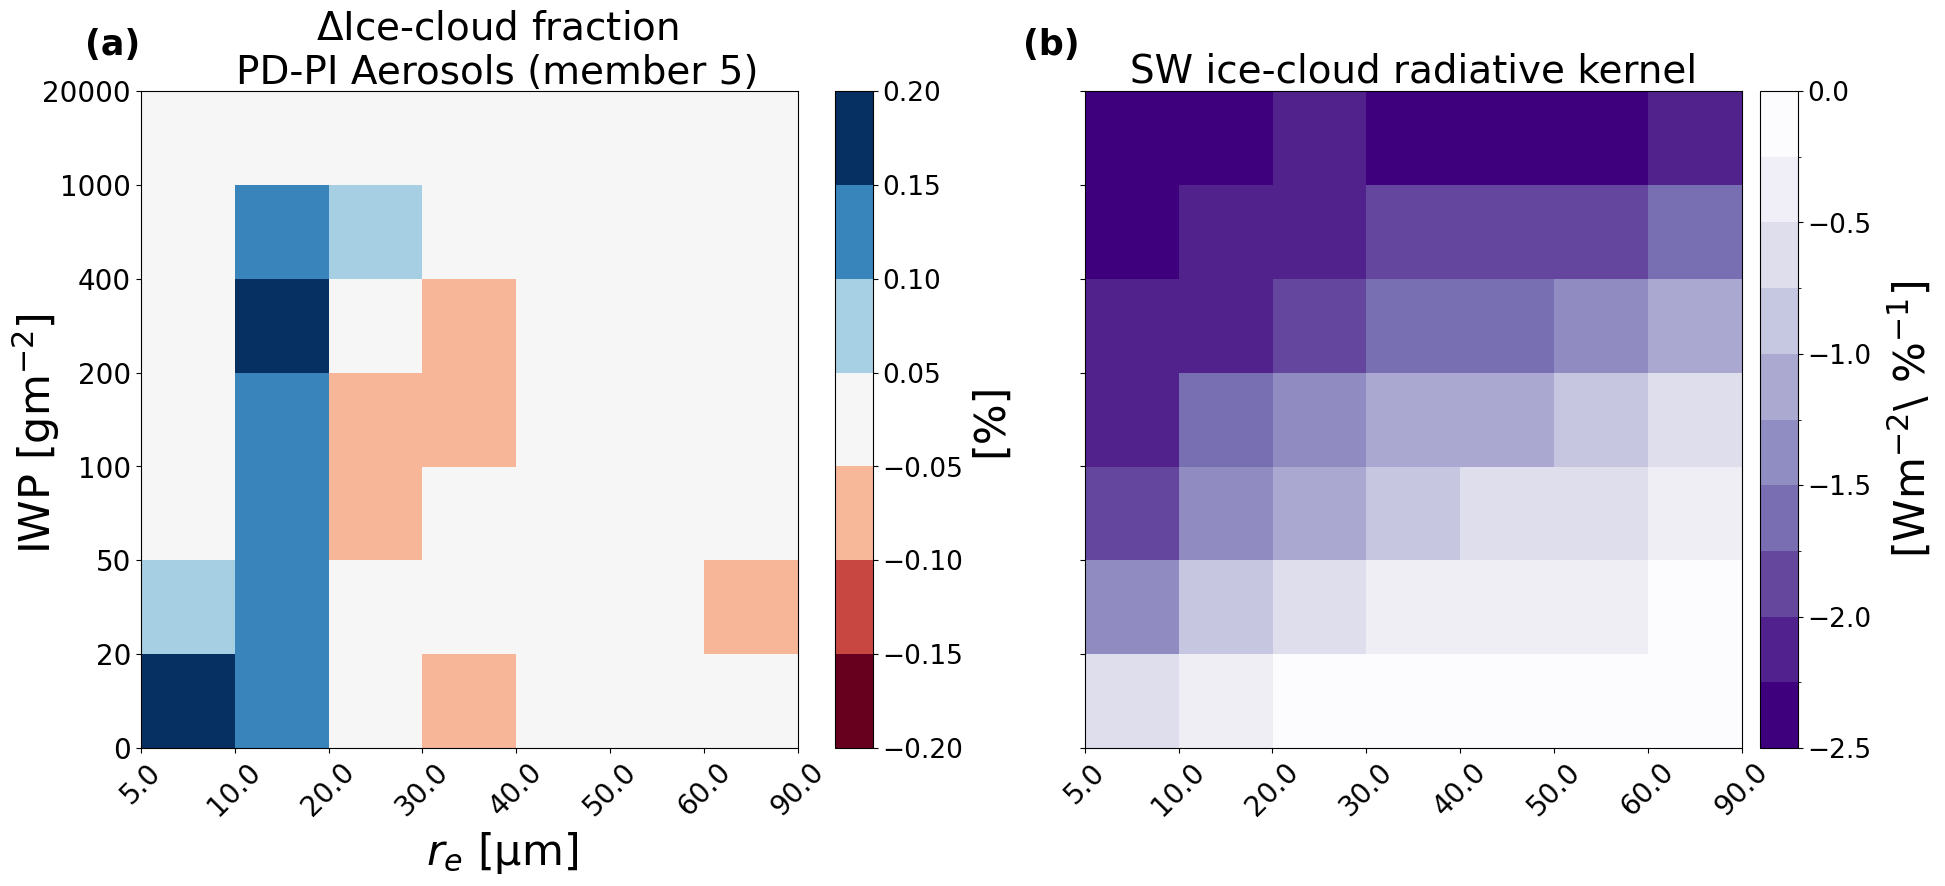

In [6]:
plot(diffCloud.CLMODIS_IWPR.transpose('cosp_iwp_modis','cosp_reffice'),swk.CLMODIS_IWPR.transpose('cosp_iwp_modis','cosp_reffice') )

### Figure 2

In [7]:
ice = xr.open_mfdataset(datapath + 'modis-ice-ACI-ensemble-mean.nc') # lat x lon
ice['SWcld_adj'] = ice.SWcld_amt + ice.SWcld_iwp + ice.SWcld_reff + ice.SWcld_err

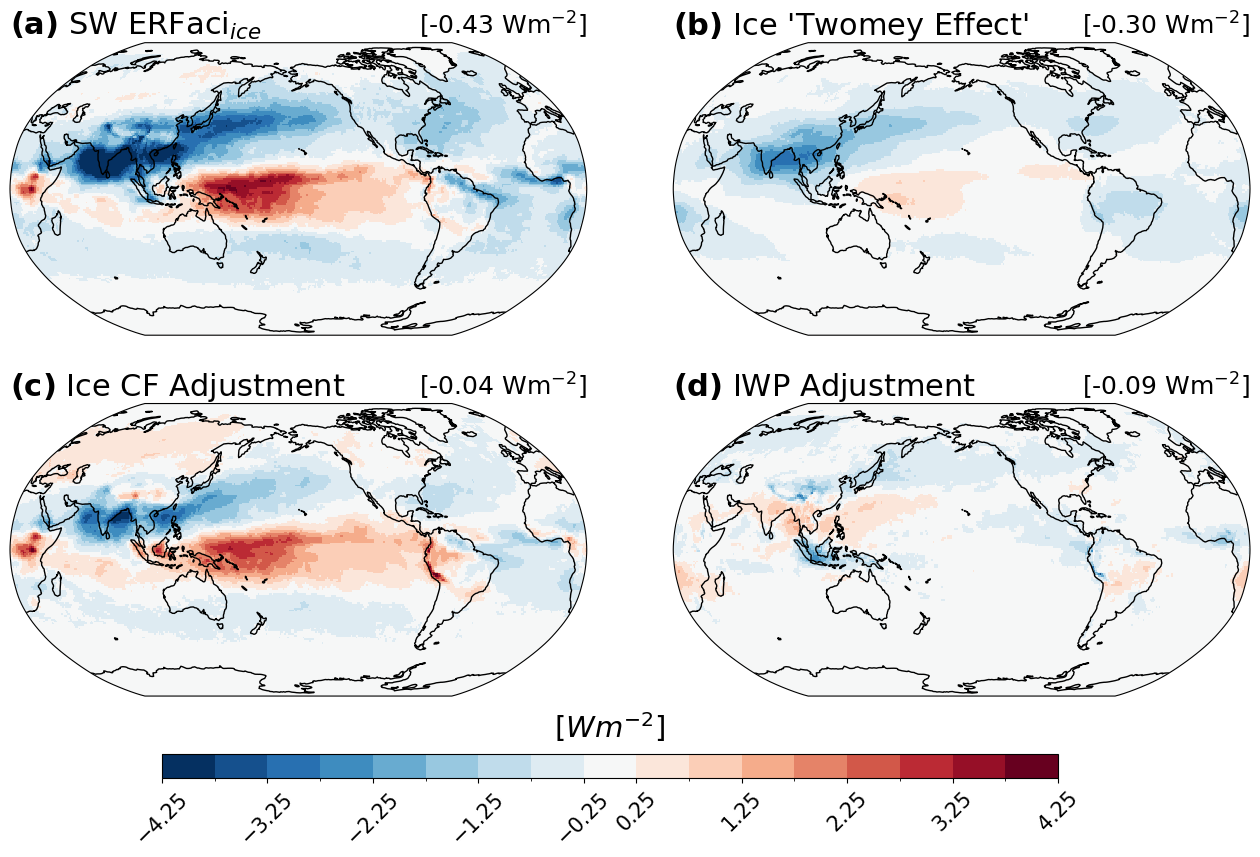

In [8]:
fig = plt.figure(figsize = (16,12))
axes = fig.subplots(nrows=2, ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=200)}).flatten()
c_bounds = np.array([-4.25,-3.75, -3.25, -2.75, -2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75,4.25])
c_ticks = [-4.25,-3.25, -2.25, -1.25, -.25, .25, 1.25, 2.25, 3.25,4.25]
cmap = plt.get_cmap('RdBu_r')
norm = mpl.colors.BoundaryNorm(c_bounds, cmap.N)#, extend='both')
fields = ['SWcld_adj','SWcld_reff','SWcld_amt','SWcld_iwp']
titles = ['SW ERFaci$_{ice}$', 'Ice \'Twomey Effect\'', 'Ice CF Adjustment','IWP Adjustment']
panels = ['(a)', '(b)', '(c)', '(d)']
avgmap = ice.bounds.add_missing_bounds()
for col in range(4):
    var = fields[col]
    avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
    avg = avg.mean()
    pl = avgmap[var].plot(ax = axes[col], 
              transform=ccrs.PlateCarree(),
              vmin = c_bounds[0], vmax = c_bounds[-1],
              cmap = cmap, norm=norm,
              extend='both',                              
              add_colorbar=False, rasterized=True)
    axes[col].set_title('{}'.format(titles[col]), size=18,loc='left')
    axes[col].set_title(rf'$\bf{panels[col]}$ ' + titles[col], size=22,loc='left')
    axes[col].set_title('[{:.2f}'.format(avg) + r' $\mathregular{Wm^{-2}}$]', size=18,loc='right')
    axes[col].coastlines()

fig.subplots_adjust(bottom=0.001)
cbar_ax = fig.add_axes([0.22, 0.1, .56, .02])
cb = fig.colorbar(pl, cax=cbar_ax, ticks=c_ticks,orientation='horizontal')
cb.ax.tick_params(labelsize=15)
cb.set_label('[$Wm^{-2}$]',size=21,labelpad=12)#,fontweight='bold')
cb.ax.xaxis.set_label_position('top')
fig.subplots_adjust(hspace=-.48, wspace=0.15) # increase wspace to increase distance between two columns; increase hspace to increase separation between two rows
cb.ax.tick_params(rotation=45)
#fig.savefig(f'./figs/ensmean-mpl-colors-labeled.jpeg', dpi=200, bbox_inches='tight', pad_inches=0.2) #seems like dpi don't affect pdf..

### Figure 3

In [9]:
file_path = datapath+'pumas.json'
members = [str(i).zfill(3) for i in range(162)]
with open(file_path, 'r') as file:
    old_dict = json.load(file)
ice,twomey, iwp, amt, err ,climodis = [],[],[],[],[],[]
for member_string in members:
    iwp.append( old_dict[member_string]['SWcld_iwp_ice'] )
    twomey.append( old_dict[member_string]['SWcld_reff_ice'])
    err.append( old_dict[member_string]['SWcld_err_ice'] )
    amt.append( old_dict[member_string]['SWcld_amt_ice'])
iwp= np.array(iwp); twomey = np.array(twomey); 
err = np.array(err); amt = np.array(amt);
iceACI = iwp + twomey + amt + err

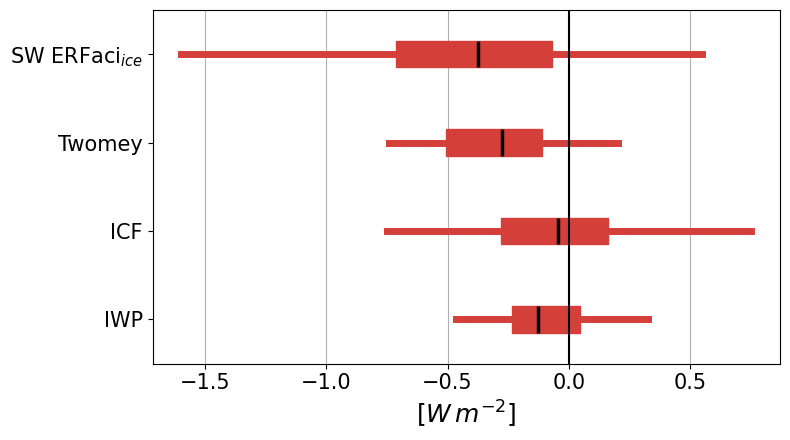

In [10]:
fig = plt.figure(figsize=(8,4.5))
ax = plt.subplot(111)

labels = [r'SW ERFaci$_{ice}$', 'Twomey', 'ICF', 'IWP']
labels.reverse()
groups = [iceACI, twomey, amt, iwp]; groups.reverse()

bp = ax.boxplot(
    groups,widths=0.3,whis=(5, 95),
    patch_artist=True,showfliers=False,showcaps=False,
    vert=False   
)

# --- Styling ---
for box in bp['boxes']:
    box.set(facecolor='#D43F3A',edgecolor='#D43F3A')#, edgecolor='black', alpha=1)

for whisker in bp['whiskers']:
    whisker.set(color='#D43F3A', linewidth=5)
for median in bp['medians']:
    median.set(color='black', linewidth=2.5)

ax.set_yticks(range(1, len(labels)+1))
ax.set_yticklabels(labels)
ax.set_xlabel(r'[$W\,m^{-2}$]', size=18)
ax.tick_params(which='both', labelsize=15)

plt.tight_layout()
plt.grid(axis='x')
plt.axvline(0,color='black')
#plt.savefig('./figs/horiz-box-and-whisker-CIs.pdf',dpi=300,bbox_inches='tight')
plt.show()


### Figure 4

In [14]:
indicesMax = np.argsort(iceACI)[-10:]  # indices of 5 largest, sorted in ascending order of value
indicesMin = np.argsort(iceACI)[:10]  # indices of 5 largest, sorted in ascending order of value

### Figure 5

In [13]:
scratch = '/glade/derecho/scratch/bduran/pumas-ens-files/'
var = 'OMEGA500'
lon_ = (0,360)
a = xc.open_mfdataset(scratch + f'{var}-PI*.nc',decode_times=False).sel(lon=slice(lon_[0],lon_[1]))#.sel(lev=slice(125,250))#.sel(lev=slice(800,902))
b = xc.open_mfdataset(scratch + f'{var}-PD*.nc',decode_times=False).sel(lon=slice(lon_[0],lon_[1]))#.sel(lev=slice(125,250))#.sel(lev=slice(800,902))
diff = ((b[var]-a[var])).load().to_dataset(name=var).bounds.add_missing_bounds()
coolPI1 = diff.isel(member=indicesMin)#.mean('member').load()
warmPI1 = diff.isel(member=indicesMax)#.mean('member').load()
coolPI_1 = coolPI1.mean('member').load()
warmPI_1 = warmPI1.mean('member').load()
coolPI_1.to_netcdf('../data/cool-OMEGA.nc')
warmPI_1.to_netcdf('../data/warm-OMEGA.nc')
var = 'NIHF'
a = xc.open_mfdataset(scratch + f'{var}-PI*.nc',decode_times=False).sel(lon=slice(lon_[0],lon_[1])).sel(lev=slice(125,250))
b = xc.open_mfdataset(scratch + f'{var}-PD*.nc',decode_times=False).sel(lon=slice(lon_[0],lon_[1])).sel(lev=slice(125,250))
diff = ((b[var]-a[var])).load().to_dataset(name=var).bounds.add_missing_bounds()
del a; del b
coolPI = diff.isel(member=indicesMin)#.mean('member').load()
warmPI = diff.isel(member=indicesMax)#.mean('member').load()
coolPI_ = coolPI.mean('member').load()
warmPI_ = warmPI.mean('member').load()
coolPI_.to_netcdf('../data/cool-NIHF.nc')
warmPI_.to_netcdf('../data/warm-NIHF')

In [ ]:
coolOmega = xc.open_dataset('../data/cool-OMEGA.nc',decode_times=False)
warmOmega = xc.open_dataset('../data/warm-OMEGA.nc',decode_times=False)
coolNIHF = xc.open_dataset('../data/cool-NIHF.nc',decode_times=False)
warmNIHF) = xc.open_dataset('../data/warm-NIHF.nc',decode_times=False)

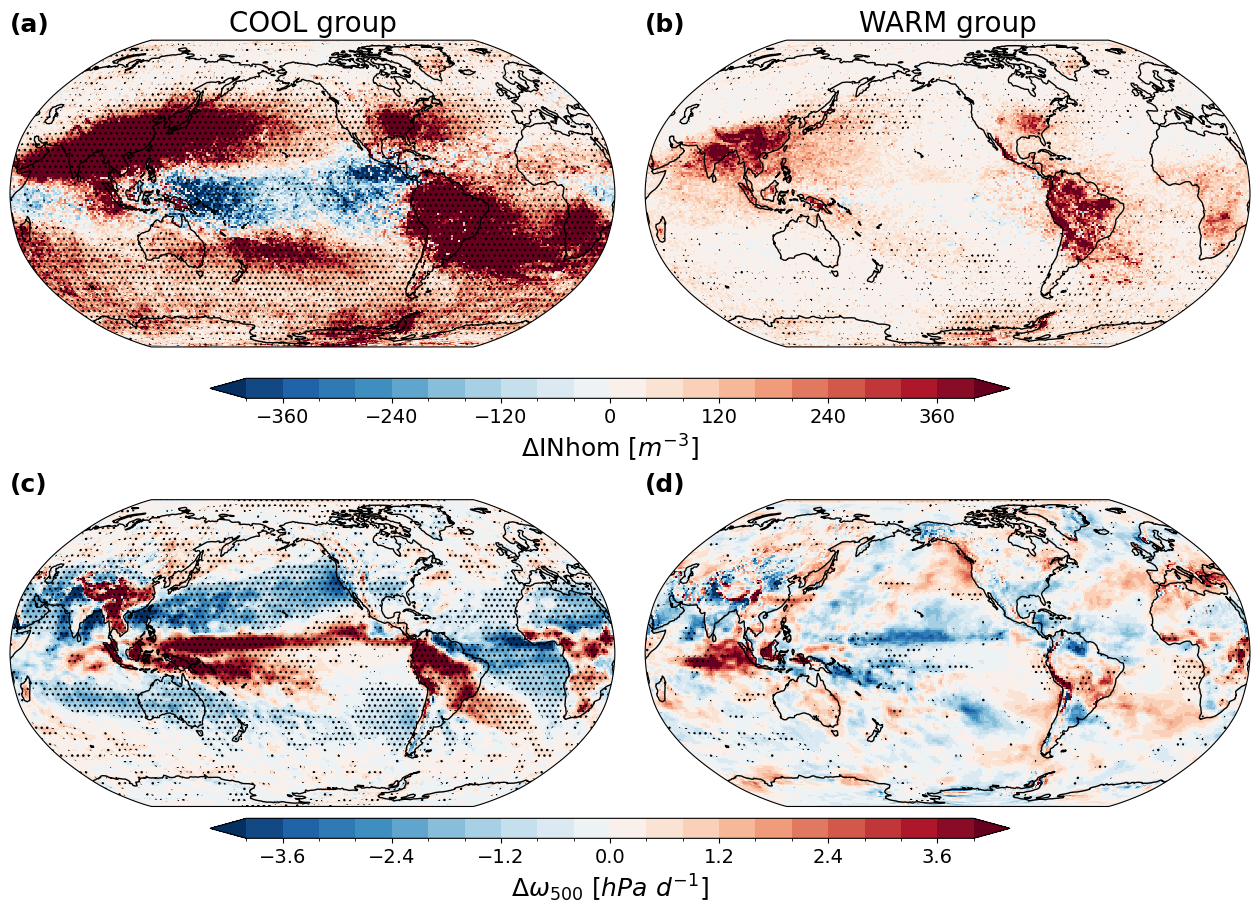

In [18]:
labels = ['COOL group', 'WARM group']
panels = ['(a)', '(b)', '(c)', '(d)']
cbarlabels = [r'$\Delta$INhom [$m^{-3}$]',r'$\Delta \omega_{500}$ [$hPa \ d^{-1}$]',r'$\Delta$INhom [$m^{-3}$]']

# Datasets for each row:
datasets_row2 = [coolPI_.NIHF.mean('lev'), warmPI_.NIHF.mean('lev')]  # ΔINhom
datasets_row1 = [coolPI_1.OMEGA500 * 864, warmPI_1.OMEGA500*864]                 # Δω500
r2 = [coolPI.NIHF.mean('lev'), warmPI.NIHF.mean('lev')]
r1 = [coolPI1.OMEGA500, warmPI1.OMEGA500]
rows = [datasets_row2, datasets_row1]
rws = [r2,r1]
cmaps = ['RdBu_r', 'RdBu_r']
levels = [np.arange(-4, 4.01, 0.4)*100,np.arange(-4, 4.01, 0.4),    # Δω500 levels
        np.arange(-4, 4.01, 0.4)*100]

fig = plt.figure(figsize=(16, 10))
for r in range(2):
    for i in range(2):
        idx = r*2 + i  # panel index
        ax = fig.add_subplot(2, 2, idx+1, projection=ccrs.Robinson(central_longitude=220))
        pl = rows[r][i].plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmaps[r], levels=levels[r],
            rasterized=True, extend='both', add_colorbar=False)
        sig = do_significance(rws[r][i])
        q = sig.plot.contourf(ax = ax, transform=ccrs.PlateCarree(),hatches=['','...'],levels=3,colors='none', add_colorbar=False)
        ax.coastlines()
        if r == 0:
            ax.set_title(labels[i], fontsize=20)
        ax.set_title(panels[idx], fontsize=18, loc='left', fontweight='bold')

    # Shared colorbar per row
    cax = fig.add_axes([0.25, 0.52 - 0.44*r, 0.5, 0.02])  # adjust y-pos per row
    cbar = plt.colorbar(pl, cax=cax, orientation='horizontal')
    cbar.set_label(cbarlabels[r], size=18)
    cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(hspace=0.48, wspace=0.05)
# Save
#plt.savefig('./figs/omega-and-hom-stipple-flip.pdf', bbox_inches='tight')
plt.show()


### Figure 6

In [6]:
scratch = '/glade/derecho/scratch/bduran/pumas-ens-files/'
var = 'Q'
save_ = False
if save_:
    a = xc.open_mfdataset(scratch + f'{var}-PI*.nc',decode_times=False).sel(lev=slice(800,902))
    b = xc.open_mfdataset(scratch + f'{var}-PD*.nc',decode_times=False).sel(lev=slice(800,902))
    diff = ((b[var]-a[var])/a[var]).load().to_dataset(name=var).bounds.add_missing_bounds()
    coolPI = diff.isel(member=indicesMin).mean('lev')#.mean('member').load()
    warmPI = diff.isel(member=indicesMax).mean('lev')#.mean('member').load()
    coolPI_ = coolPI.mean('member').load()
    warmPI_ = warmPI.mean('member').load()
    coolPI_.to_netcdf('../data/cool-BL_Q.nc')
    warmPI_.to_netcdf('../data/warm-BL_Q.nc')
coolPI_ = xc.open_dataset('../data/cool-BL_Q.nc',decode_times=False)
warmPI_ = xc.open_dataset('../data/warm-BL_Q.nc',decode_times=False)

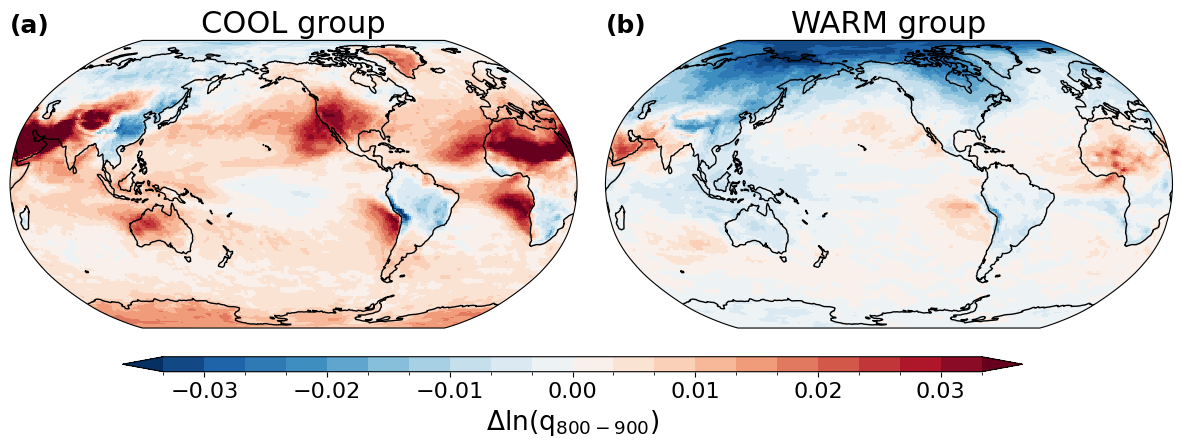

In [7]:
labels = ['Ensemble','COOL group',r'WARM group', 'Convective precipitation']
cbarlabel = r'$\Delta$ln(q$_{800-900}$)'
units = ['','']; panels = ['(a)','(b)']
fig = plt.figure(figsize=(15, 5))
cmap = 'RdBu_r'
t_levels = np.arange(-4, 4.01, 0.4)/120
datasets = [coolPI_.Q,warmPI_.Q]

for i, (a, label) in enumerate(zip(datasets, labels), start=1):
    ax = fig.add_subplot(1, 2, i, projection=ccrs.Robinson(central_longitude=220))
    pl = (a).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cmap,
                  levels=t_levels,rasterized=True, extend='both',add_colorbar=False)
    ax.coastlines()
    ax.set_title(rf'{labels[i]}', fontsize=22, loc='center')
    ax.set_title(f'{panels[i-1]}', fontsize=18, loc='left',fontweight='bold')
cax = fig.add_axes([0.2,.12,.6,.03])
cbar = plt.colorbar(pl,cax=cax,  pad=0.02,orientation='horizontal')
cbar.set_label(cbarlabel, size=19)
cbar.ax.tick_params(labelsize=16)
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
#plt.savefig(f'./figs/q800-900-spatial-cool-v-warm-stipple.pdf', bbox_inches='tight')
plt.show()

### Figure 7

In [29]:
vars=['thetaE','Q','PRECC'] + ['theta','T']#,'FREQZM']#,'CLOUD']
save_ = False
if save_:
    path = [scratch + f'{var}-PI-all-members.nc' for var in vars]
    pi = xc.open_mfdataset(path,decode_times=False,compat='override').isel(member=indicesMin)
    pi['s'] = pi.theta.sel(lev=slice(100,300)).mean('lev')# - pi.theta.sel(lev=slice(700,925)).mean('lev')
    path1 = [scratch + f'{var}-PD-all-members.nc' for var in vars]
    pd = xc.open_mfdataset(path1,decode_times=False,compat='override').isel(member=indicesMin)
    pd['s'] = pd.theta.sel(lev=slice(100,300)).mean('lev')# - pd.theta.sel(lev=slice(700,925)).mean('lev')
    bltop = 800
    x1 = ((pd.Q - pi.Q)).sel(lev=slice(bltop,900)).mean('lev').load()
    x3 = (pd.thetaE - pi.thetaE).sel(lev=slice(bltop,900)).mean('lev').load()
    x5 = (pd.PRECC - pi.PRECC).load()
    x4 = (pd.s - pi.s).load()
    ds = xr.merge([x1,x3,x5,x4])
    ds.to_netcdf('../data/COOL-pathway.nc')
ds = xc.open_dataset('../data/COOL-pathway.nc', decode_times=False)
coolMean = ds.mean('member').load()

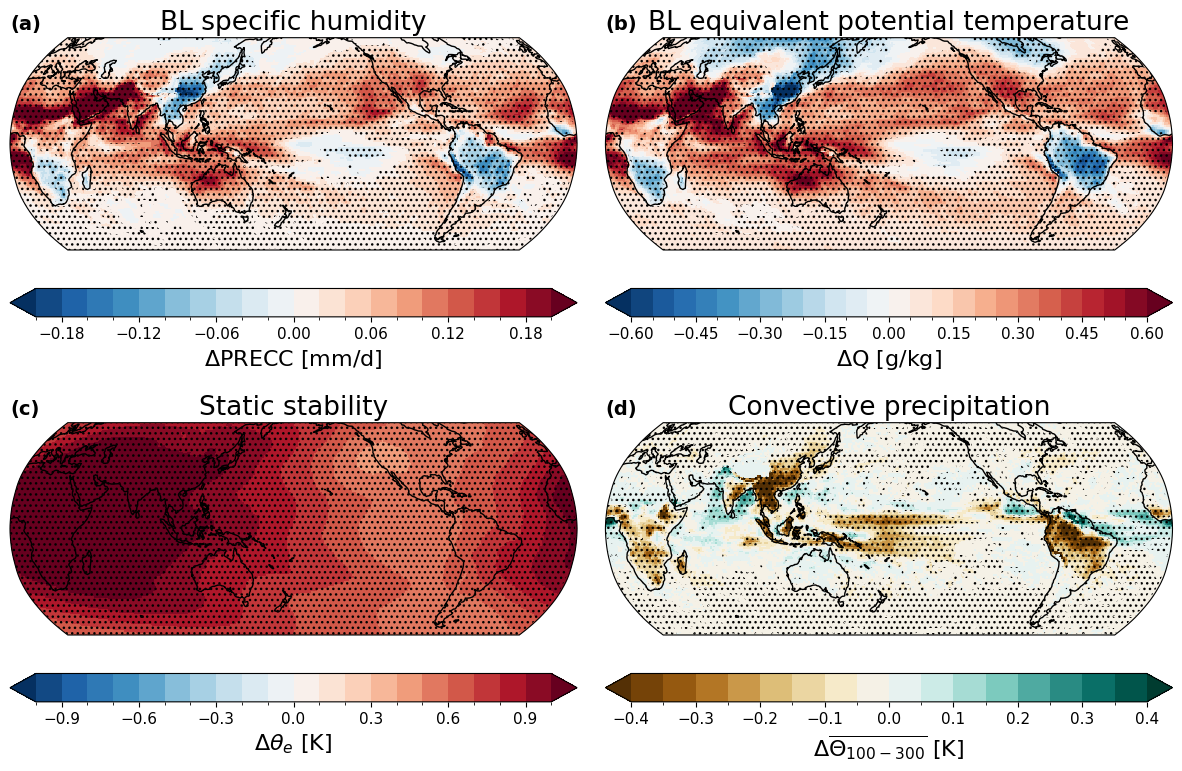

In [32]:
labels = ['BL specific humidity','BL equivalent potential temperature',r'Static stability', 'Convective precipitation']
cbarlabels = ['Q',r'$\theta_e$',r'$\overline{\Theta_{100-300}}$', 'PRECC']
units = ['g/kg','K','K','mm/d']
panels = ['(a)','(b)','(c)','(d)']
fig = plt.figure(figsize=(15, 10))
cmap = 'RdBu_r'
t_levels = [np.arange(-4, 4.01, 0.4)/20,np.arange(-.6,.61,.05),np.arange(-1,1.01,.1),np.arange(-.4,.41,.05)]
conversions = [1000,1,1,8.64E7]
variables = ['Q','thetaE','s','PRECC']

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.Robinson(central_longitude=180))
    var = variables[i]
    if i == 3:
        cmap = plt.get_cmap('BrBG')
    pl = (coolMean[var].sel(lat=slice(-60,60))*conversions[i]).plot(
        ax=ax,transform=ccrs.PlateCarree(),cmap=cmap,levels=t_levels[i],rasterized=True,
        extend='both',cbar_kwargs={'orientation':'horizontal','pad':0.1,'label': cbarlabels[i] + ' [' + units[i] + ']'})
    sig = do_significance(ds[var].sel(lat=slice(-60,60)))
    q = sig.plot.contourf(ax = ax, transform=ccrs.PlateCarree(),hatches=['','...'],levels=3,colors='none', add_colorbar=False)
    ax.coastlines()
    ax.set_title(rf'{labels[i]}', fontsize=19, loc='center')
    ax.set_title(f'{panels[i]}', fontsize=14, loc='left',fontweight='bold')
    im = ax.collections  
    cb = im[0].colorbar  
    cb.set_label(r'$\Delta$' + cbarlabels[i-1] + ' [' + units[i-1] + ']',fontsize=16)
    cb.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig(f'./figs/cool-group-pathway-{str(bltop)}2.pdf',bbox_inches='tight')

plt.show()

### Figure 8

In [21]:
vars=['trueACTNI','trueACTREI','TGCLDIWP','CLIMODIS']# + ['theta','T']#,'FREQZM']#,'CLOUD']
save_ = False
if save_:
    path = [scratch + f'{var}-PI-all-members.nc' for var in vars]
    pi = xc.open_mfdataset(path,decode_times=False,compat='override').sel(lat=slice(-60,60)).isel(member=indicesMin)
    path1 = [scratch + f'{var}-PD-all-members.nc' for var in vars]
    pd = xc.open_mfdataset(path1,decode_times=False,compat='override').sel(lat=slice(-60,60)).isel(member=indicesMin)
    x1 = ((pd.trueACTREI - pi.trueACTREI)).load()
    x3 = (pd.trueACTNI - pi.trueACTNI).load()
    x5 = (pd.CLIMODIS - pi.CLIMODIS).load()
    x4 = (pd.TGCLDIWP - pi.TGCLDIWP).load()
    ds = xr.merge([x1,x3,x4,x5])
    ds.to_netcdf('../data/COOL-microphysics.nc')
ds = xc.open_mfdataset('../data/COOL-microphysics.nc',decode_times=False)
coolMean = ds.mean('member').load()

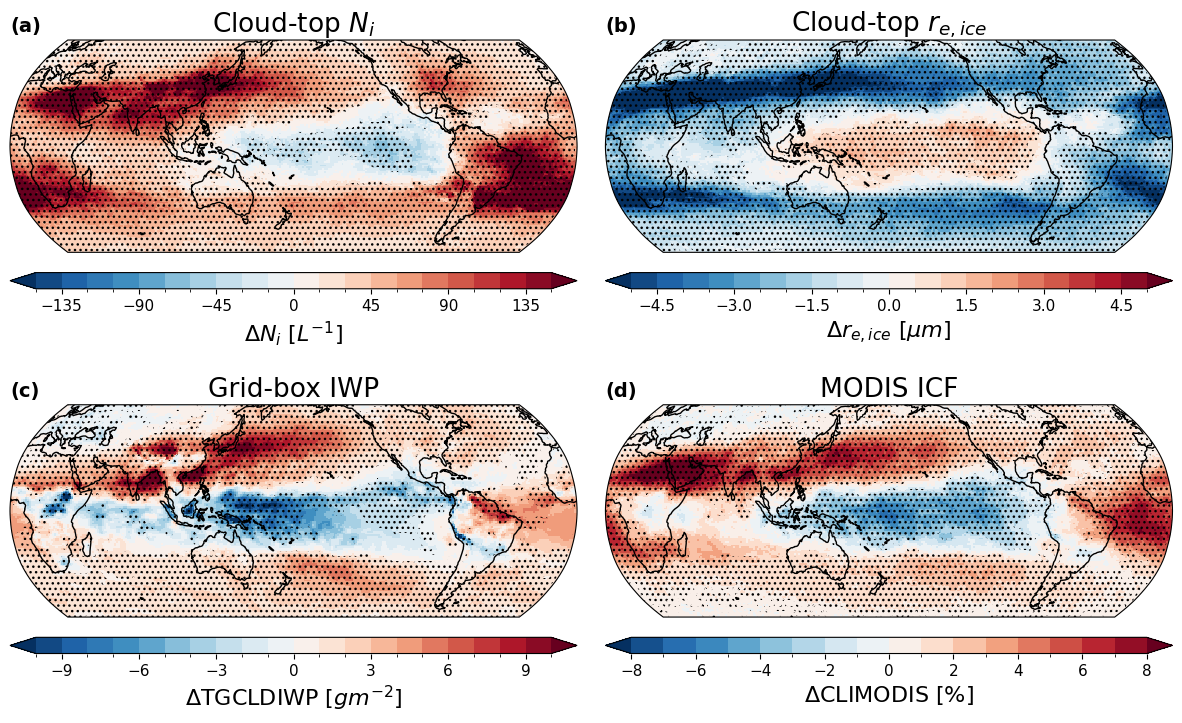

In [27]:
labels = ['Cloud-top $N_i$','Cloud-top $r_{e,ice}$', 'Grid-box IWP', 'MODIS ICF']
cbarlabels = [ r'$\Delta N_{i}$ [$L^{-1}$]',r'$\Delta r_{e,ice}$ [$\mu m$]',r'$\Delta$TGCLDIWP [$gm^{-2}$]', r'$\Delta$CLIMODIS [%]']
units = [' $L^{-1}$]',' microns]',' $gm^{-2}$]',' %]']
conversions = [1/1000,1, 1000, 1]
panels = ['(a)','(b)','(c)','(d)']
fig = plt.figure(figsize=(15, 10))
cmap = 'RdBu_r'
c_bounds = [np.arange(-75,75.1,7.5)*2,np.arange(-5,5.1,.5),np.arange(-5,5.1,.5)*2,np.arange(-8,8.1,1)]
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.Robinson(central_longitude=180))
    var = vars[i]
    pl = (coolMean[var] * conversions[i]).plot(
        ax=ax,transform=ccrs.PlateCarree(),cmap=cmap,levels=c_bounds[i],rasterized=True,
        extend='both',cbar_kwargs={'orientation':'horizontal','pad':0.05,'label': cbarlabels[i] + ' [' + units[i] + ']','aspect':35}
    )
    sig = do_significance(ds[var])
    q = sig.plot.contourf(ax = ax, transform=ccrs.PlateCarree(),hatches=['','...'],levels=3,colors='none', add_colorbar=False)
    ax.coastlines()
    ax.set_title(rf'{labels[i]}', fontsize=19, loc='center')
    ax.set_title(f'{panels[i]}', fontsize=14, loc='left',fontweight='bold')
    im = ax.collections  
    cb = im[0].colorbar  
    cb.set_label(cbarlabels[i],fontsize=16)
    cb.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=-.1)
#plt.savefig(f'./figs/cool-group-microphysics-stipple.pdf',bbox_inches='tight')
plt.show()

### Figure 9

In [20]:
process_obs = False
if process_obs:
    # Get observations 
    # CERES
    base = datapath #base = '/glade/work/bduran/CERES-data/'
    var = 'toa_cre_lw_mon'
    ds = xc.open_mfdataset(base + 'CERES_EBAF_Ed4.2_Subset_200003-202405.nc')#.sum(['cloud_water_path_ice','cloud_particle_size_ice']).bounds.add_missing_bounds()
    lwflux = ds[var].to_dataset(name=var).bounds.add_missing_bounds(axes=('X','Y','T'))
    gmlw = lwflux.spatial.average(var)[var].load().to_numpy()
    gmlwobs = gmlw.mean()
    # MODIS
    icfobs1 = xc.open_mfdataset('/glade/work/bduran/modis-obs/modis-cosp-Cloud_Water_Path_vs_Cloud_Particle_Size_Ice-4102025.nc',decode_times=False).sum(['cloud_water_path_ice','cloud_particle_size_ice']).load()
    icfobs1['date'].attrs['axis'] = 'T'
    gmicfobs = icfobs1.spatial.average('Cloud_Water_Path_vs_Cloud_Particle_Size_Ice').Cloud_Water_Path_vs_Cloud_Particle_Size_Ice
    modishist = gmicfobs.to_numpy()
    modishist *=100 # convert to percent
    gmModis = modishist.mean()
    #gmModis

In [21]:
# Get model data
icf,lwcf = [],[]
for member_string in members:
    icf.append( old_dict[member_string]['CLIMODIS']['PD'] )
    lwcf.append( old_dict[member_string]['LWCF']['PD'])
icf= np.array(icf); lwcf = np.array(lwcf);

# Obs files are too large to be hosted on Github
# Use processed values; datasets are available on Zenodo for reproduction
gmModis = 17.249 # from file modis-cosp-Cloud_Water_Path_vs_Cloud_Particle_Size_Ice-4102025.nc
gmlwobs = 25.598902 # from file CERES_EBAF_Ed4.2_Subset_200003-202405.nc

In [22]:
# Construct observed PDFs
xs = np.linspace(icf.min()-4, icf.max()-30, 400)
kde_x = gaussian_kde(modishist)
pdf_x = kde_x(xs)
# normalize pdf to axis height
pdf_x /= pdf_x.max()
ys = np.linspace(lwcf.min(), lwcf.max()-20, 400)
kde_y = gaussian_kde(gmlw)
pdf_y = kde_y(ys)
pdf_y /= pdf_y.max()

# Euclidean distance metric
xgrid = np.linspace(iceACI.min(), iceACI.max()+0.5, 400)
sig_lw   = np.std(lwcf)
sig_icf  = np.std(icf)
dist_lw  = (lwcf - gmlwobs) / sig_lw
dist_icf = (icf  - gmModis) / sig_icf
# Combined Euclidean distance
alpha = 1.0
D = np.sqrt(dist_lw**2 + dist_icf**2)
weights = np.exp(-alpha * D)
weights = weights / weights.sum() # normalize weights
aci_weighted = gaussian_kde(iceACI, weights=weights)
kde_raw = gaussian_kde(iceACI)

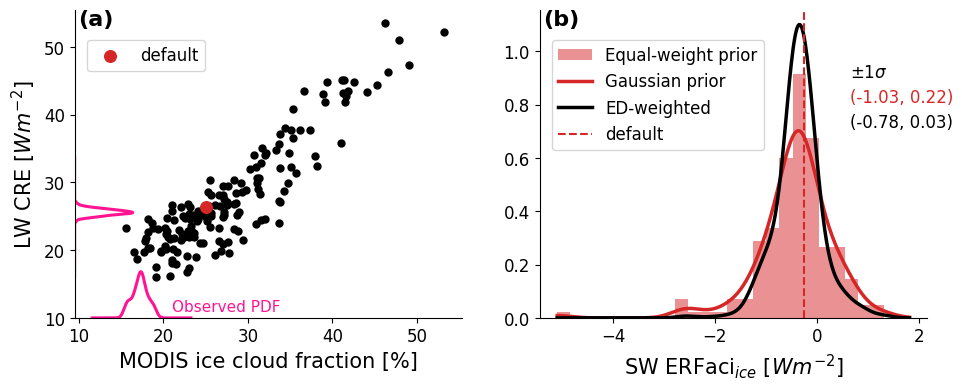

In [23]:
plt.figure(figsize=(11,4))
plt.rcParams['lines.markersize'] = 5  # controls default marker size
ax = plt.subplot(121)
plt.scatter(icf, lwcf,color='black')
plt.scatter(icf[0], lwcf[0],edgecolor='tab:red',label='default',color='tab:red',marker='o',s=70)
plt.xlabel('MODIS ice cloud fraction [%]',size=15)
plt.ylabel(r'LW CRE [$Wm^{-2}$]',size=15)
plt.ylim(bottom = 10)
plt.text(0.01,0.95,'(a)',fontweight='bold',size=16,transform=ax.transAxes)
ax.plot(xs, pdf_x * 0.15,  # scale height (adjust 0.15 if too tall)
        transform=ax.get_xaxis_transform(),color='deeppink',linewidth=2.2)
ax.plot(pdf_y * 0.15, ys,   # scale width
        transform=ax.get_yaxis_transform(),color='deeppink',linewidth=2.2)
ax.spines[['right','top']].set_visible(False)
ax.tick_params(labelsize=12)
plt.text(21,11,'Observed PDF',size=11,color='deeppink')
plt.legend(fontsize=12,bbox_to_anchor=(0.01,0.93),loc='upper left')
ax = plt.subplot(122)
# Raw PDF
plt.hist(iceACI, bins=25, color='tab:red', alpha=0.5, density=True, label='Equal-weight prior')
plt.plot(xgrid, kde_raw(xgrid), color='tab:red', linewidth=2.5,label='Gaussian prior')
plt.plot(xgrid, aci_weighted(xgrid), color='black',linewidth=2.5,label='ED-weighted')
plt.axvline(iceACI[0],color='tab:red',linestyle='--',label='default')
plt.text(0.01,0.95,'(b)',fontweight='bold',size=16,transform=ax.transAxes)
plt.xlabel(r'SW ERFaci$_{ice} \ [Wm^{-2}$]',size=15)
ax.spines[['right','top']].set_visible(False)
ax.tick_params(labelsize=12)
plt.legend(fontsize=12,bbox_to_anchor=(0.01,0.93),loc='upper left')
# Add 68% confidence intervals
plt.text(0.8,0.78,r'$\pm1\sigma$',color='black',transform=ax.transAxes,size=12)
plt.text(0.8,0.7,'(-1.03, 0.22)',color='tab:red',transform=ax.transAxes,size=12)
plt.text(0.8,0.62,'(-0.78, 0.03)',color='black',transform=ax.transAxes,size=12)
#plt.savefig('./figs/new-constraint-two-panels-w-bounds1.jpeg',dpi=900,bbox_inches='tight')
#plt.savefig('./figs/new-constraint-two-panels-w-bounds1.pdf',dpi=300,bbox_inches='tight')
plt.show()

## Appendix figures

### fig 1

### fig 2

In [10]:
# Open existing data
file_path = datapath + 'pumas.json'
with open(file_path, 'r') as file:
    old_dict = json.load(file) #used to be old_dict
members = [str(i).zfill(3) for i in range(162)]
ice,twomey, cwp, amt, err ,climodis = [],[],[],[],[],[]
a, b,c,d = [],[],[],[]
for member_string in members:
    cwp.append( old_dict[member_string]['SWcld_iwp_ice'] + old_dict[member_string]['SWcld_lwp_liq']  )
    twomey.append( old_dict[member_string]['SWcld_reff_ice'] + old_dict[member_string]['SWcld_reff_liq'] )
    err.append( old_dict[member_string]['SWcld_err_ice'] + old_dict[member_string]['SWcld_err_liq']  )
    amt.append( old_dict[member_string]['SWcld_amt_ice'] + old_dict[member_string]['SWcld_amt_unobscured_liq'] )
    b.append( old_dict[member_string]['SW_AIE_ghan'] ); d.append( old_dict[member_string]['cld_aprp'] )
cwp= np.array(cwp); twomey = np.array(twomey); 
err = np.array(err); amt = np.array(amt);
ghan = np.array(b); aprp = np.array(d)
tot = cwp + amt + twomey +err

/glade/derecho/scratch/bduran/tmp/ipykernel_28373/2301227441.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[k].plot(lims, lims, 'k-', linewidth=2.5, zorder=1,linestyle='--')


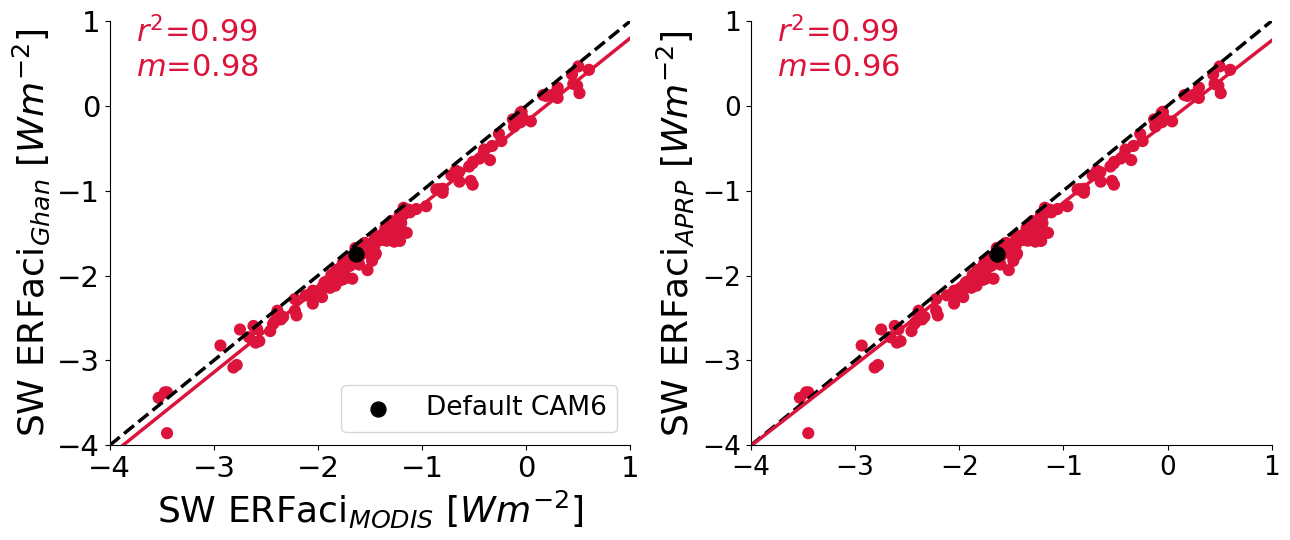

In [11]:
ylabels = ["SW ERFaci$_{Ghan}$ [$Wm^{-2}$]", "SW ERFaci$_{APRP}$ [$Wm^{-2}$]"]
c_ = 'crimson'#'deeppink'# 'teal'#'lightseagreen'
colors = [c_] * len(ghan)  # Default color is blue
fig, axes = plt.subplots(ncols=2,figsize = (6.5*2,5.5))#.flatten()
labels = ['(a) SW ERF$_{aci, Ghan}$ and SW ERF$_{liq+ice}$', '(b) SW ERF$_{aci, APRP}$ and SW ERF$_{liq+ice}$']#,'(b) SW ERF$_{ari}$','(c) SW ERF$_{aci}$','(d) $\Delta$ SW$_{alb}$']
axes[0].scatter(tot, ghan,c=colors,s=60)
axes[0].scatter(tot[0], ghan[0], c='black', label='Default CAM6', s=115,zorder=5)
axes[1].scatter(tot, ghan,c=colors,s=60)
axes[1].scatter(tot[0], ghan[0], c='black', label='Default CAM6', s=115,zorder=5)
lims = [-4,1]
which_method = [ghan, aprp]
for k in range(2):
    axes[k].plot(lims, lims, 'k-', linewidth=2.5, zorder=1,linestyle='--')
    axes[k].set_xlim([lims[0],lims[1]])        
    axes[k].set_ylim([lims[0],lims[1]])        
    rsq, fit_y, slope = do_fit(tot, which_method[k], lims[0],lims[1])
    axes[k].plot( np.linspace(lims[0], lims[1], 150), fit_y, linewidth=2.5,color=c_)
    axes[k].text(0.05, 0.95, '$r^2$'+f'={round(rsq,2)}', size=22, transform=axes[k].transAxes,color=c_)#,fontweight='bold')
    axes[k].text(0.05, 0.87, '$m$'+f'={round(slope,2)}', size=22, transform=axes[k].transAxes,color=c_)#,fontweight='bold')
    axes[k].tick_params(axis='both', which='major', labelsize=19)  # For major ticks

axes[0].set_ylabel(ylabels[0], size=26)
axes[1].set_ylabel(ylabels[1], size=26)
axes[0].legend(loc='lower right', fontsize=19)#,frameon=False)
axes[0].tick_params(axis='y', labelsize=21)
axes[0].tick_params(axis='x', labelsize=21)
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[0].set_xlabel("SW ERFaci$_{MODIS}$ [$Wm^{-2}$]", size=26)
plt.tight_layout()
#fig.savefig('./figs/gm-method-comparisons-ghan.pdf', bbox_inches='tight')
plt.show()

### fig 3

In [8]:
datafile_param = datapath + "parameter-ranges-v2-w-control.nc"
ds_param = xr.open_mfdataset(datafile_param)
# Normalize our parameters
members = [str(i).zfill(3) for i in range(162)]
def normalize_array(arr):
    norm_arr = (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    return norm_arr
norm_params = []
for param in list(ds_param.data_vars):
    if param == 'Sample_nmb':   continue
    tmp = ds_param[param].to_numpy()
    da_tmp = xr.DataArray(normalize_array(tmp), name=param, dims='nmb_sim')
    norm_params.append( da_tmp )    
norm_param = xr.merge(norm_params)#.drop_sel({'nmb_sim':75}).drop_sel({'nmb_sim':0})

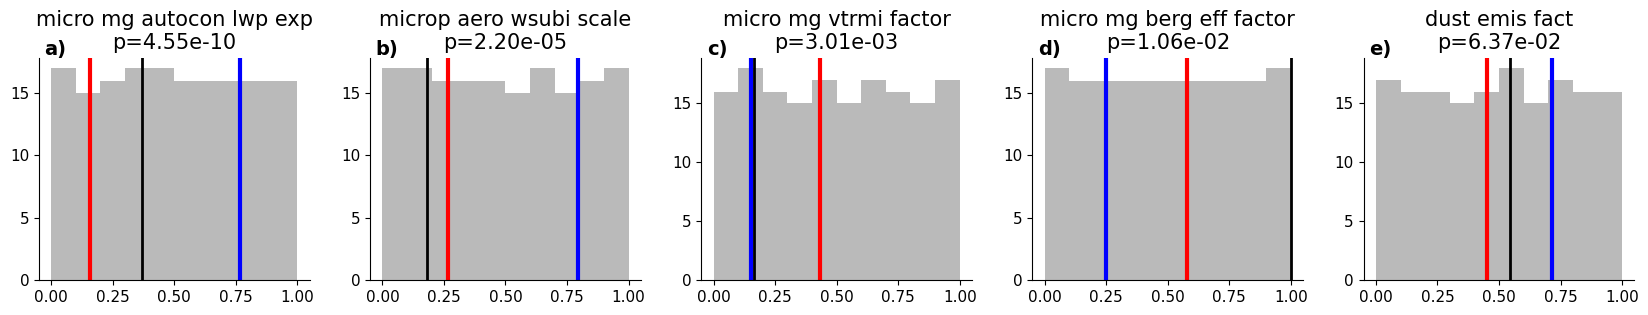

In [9]:
ncols = 6
diff_thresh = 0.1

# --- First pass: compute p-values AND mean differences ---
stats = {}

for var in norm_param.data_vars:
    data = norm_param[var]

    COOL = data[indicesMin].values
    WARM = data[indicesMax].values

    # Means
    cool_mean = np.mean(COOL)
    warm_mean = np.mean(WARM)
    mean_diff = np.abs(COOL.mean() - WARM.mean())

    # T-test
    tstat, pval = ttest_ind(COOL, WARM, equal_var=False)

    # Skip variables that don't meet the threshold
    if pval >= diff_thresh:
        continue

    stats[var] = {
        "pval": pval,
        "diff": mean_diff,
        "cool_mean": cool_mean,
        "warm_mean": warm_mean
    }

# --- Sort variable names by p-value (ascending significance) ---
sorted_vars = sorted(stats.keys(), key=lambda v: stats[v]["pval"])
panels=['a)','b)','c)','d)','e)']
nvars = len(sorted_vars)
nrows = int(np.ceil(nvars / ncols))

# --- Create figure ---
fig, axes = plt.subplots(nrows, ncols, figsize=(20,3.25))
axes = axes.ravel()

# --- Plot filtered + sorted variables ---
for i, var in enumerate(sorted_vars):
    ax = axes[i]
    data = norm_param[var]

    pval = stats[var]["pval"]
    COOL = stats[var]["cool_mean"]
    WARM = stats[var]["warm_mean"]

    # 1D case
    if data.ndim == 1:
        ax.hist(data, color='darkgrey', alpha=0.8)
        ax.axvline(COOL, color='blue', linewidth=3)
        ax.axvline(WARM, color='red', linewidth=3)
        ax.axvline(data[0], color='black', linewidth=2,zorder=10)

    # 2D case
    elif data.ndim == 2:
        im = ax.imshow(data, aspect='auto', origin='lower')
        fig.colorbar(im, ax=ax, shrink=0.7)

    else:
        ax.text(0.5, 0.5, "Can't plot ndim > 2",
                ha='center', va='center', transform=ax.transAxes)
    var = var.replace("_"," ")
    ax.set_title(f"{var}\np={pval:.2e}",size=15)
    ax.text(0.02,1.01,panels[i],size=14,transform=ax.transAxes,fontweight='bold')
    ax.spines[['right','top']].set_visible(False)
    ax.tick_params(which='both',labelsize=11)

# --- Remove unused axes ---
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
#plt.savefig('./figs/most-diff-params-cool-warm.pdf',dpi=300,bbox_inches='tight')
plt.show()


### fig 4

In [ ]:
labels = ['Ice cloud fraction','Specific humidity', 'Vertical velocity', 'MODIS ICF']
cbarlabels = [ r'$\Delta$ICF [%]',r'$\Delta$ln(q$_{800-900}$)',r'$\Delta \omega_{500}$ [$Pa \ s^{-1}$]', r'$\Delta$CLIMODIS [%]']
panels = ['(a)','(b)','(c)','(d)']
fig = plt.figure(figsize=(15, 10))
cmap = 'RdBu_r'
c_bounds = [np.arange(-4,4.1,.5),np.arange(-3.5,3.51,.5)/100,np.arange(-3.5,3.51,.5)/1000,np.arange(-8,8.1,1)]
datasets = [dicf.CLIMODIS, dlnq.Q, domega.OMEGA500]
datasets = [i.sel(lat=slice(-60,60)) for i in datasets]

for i, (a, label) in enumerate(zip(datasets, labels), start=1):
    ax = fig.add_subplot(2, 2, i, projection=ccrs.Robinson(central_longitude=180))
    pl = (a).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cmap,levels=c_bounds[i-1],rasterized=True,
        extend='both',cbar_kwargs={'orientation':'horizontal','pad':0.05,'label': cbarlabels[i-1] + ' [' + units[i-1] + ']','aspect':35}
    )
    ax.coastlines()
    ax.set_title(rf'{labels[i-1]}', fontsize=19, loc='center')
    ax.set_title(f'{panels[i-1]}', fontsize=14, loc='left',fontweight='bold')
    im = ax.collections  
    cb = im[0].colorbar  
    cb.set_label(cbarlabels[i-1],fontsize=16)
    cb.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=-.1)

#plt.savefig(f'./figs/old-ppe.pdf',bbox_inches='tight')
plt.show()